In [22]:
import feyn
from feyn.plots.interactive import interactive_activation_flow
from feyn.tools import split

import pandas as pd

from sklearn.metrics import root_mean_squared_error

In [24]:
df = pd.read_csv("/Users/admin/Downloads/parklane_edited.csv")

In [25]:
# fill NaN cells with 0
df.fillna(0)

,timestamp,sys_kw,sys_cl,sys_hr,sys_hb,sys_eff,ch_sysef,air_eff,h_chwst,h_chwrt,...,ahu_ilp_1_ph,ahu_ilp_1_mvp,ahu_ilp_1_fl,ahu_ilp_1_freq,ahu_ilp_1_rpm,ahu_ilp_2_ph,ahu_ilp_2_mvp,ahu_ilp_2_fl,ahu_ilp_2_freq,ahu_ilp_2_rpm
0,12/3/23 00:00,0.693672,0.032793,0.0,0.0,31.291697,22.072638,9.275530,18.472595,20.528137,...,0.0,27.560001,0.0,0.0,0.0,0.0,27.560001,0.0,0.0,0.0
1,12/3/23 00:01,0.707719,0.033077,0.0,0.0,32.503700,21.382240,8.901477,18.464382,20.534977,...,0.0,27.560001,0.0,0.0,0.0,0.0,27.560001,0.0,0.0,0.0
2,12/3/23 00:02,0.716781,0.032619,0.0,0.0,30.604588,21.109730,8.676921,18.491760,20.536346,...,0.0,27.560001,0.0,0.0,0.0,0.0,27.560001,0.0,0.0,0.0
3,12/3/23 00:03,0.695813,0.031427,0.0,0.0,30.649281,22.140791,9.313333,18.480808,20.534977,...,0.0,27.560001,0.0,0.0,0.0,0.0,27.560001,0.0,0.0,0.0
4,12/3/23 00:04,0.712188,0.033932,0.0,0.0,28.393875,21.863008,9.105909,18.484915,20.536346,...,0.0,27.560001,0.0,0.0,0.0,0.0,27.560001,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493915,7/2/24 23:55,0.659313,0.014084,0.0,0.0,69.313881,48.457237,21.396702,12.612066,13.368400,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
493916,7/2/24 23:56,0.647156,0.013102,0.0,0.0,73.751755,49.394348,21.862408,12.614863,13.360059,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
493917,7/2/24 23:57,0.644875,0.013533,0.0,0.0,69.183479,47.650959,21.327015,12.617662,13.382298,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
493918,7/2/24 23:58,0.655438,0.013829,0.0,0.0,66.936768,47.395973,21.024706,12.621859,13.397586,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [26]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=0) & (df['pchwp_1_kw'] <=25)]
#df = df[(df['pchwp_2_kw'] >=0) & (df['pchwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] >= 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] >= 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >=0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=0) & (df['sys_cl']<=600)]
df = df[(df['sys_hr']>=0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>=0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.3) & (df['ch_sysef']<=0.8)]

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
# combining total power input of both chillers
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']

fil_df.reset_index()


/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_853/3347044724.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_853/3347044724.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']


,index,timestamp,sys_kw,sys_cl,sys_hr,sys_hb,sys_eff,ch_sysef,air_eff,h_chwst,...,ahu_ilp_1_fl,ahu_ilp_1_freq,ahu_ilp_1_rpm,ahu_ilp_2_ph,ahu_ilp_2_mvp,ahu_ilp_2_fl,ahu_ilp_2_freq,ahu_ilp_2_rpm,lift,ct_tot_kw
0,635,12/3/23 10:35,49.378506,127.538132,142.273010,-7.788623,0.760313,0.387167,0.374602,19.742857,...,119.240005,26.162006,2589.0,4.940001,27.560001,129.360001,26.121365,2572.0,7.367701,3.508719
1,636,12/3/23 10:36,47.122364,152.515945,131.309479,22.068899,0.622407,0.308619,0.312583,19.432108,...,119.680016,26.141687,2579.0,5.020000,27.560001,127.160011,26.355047,2577.0,7.805637,3.477781
2,637,12/3/23 10:37,49.685364,126.885735,129.005188,6.926045,0.765892,0.391576,0.375121,19.530668,...,118.800011,26.162006,2575.0,4.940001,27.560001,129.800003,26.487127,2607.0,8.073826,7.184000
3,638,12/3/23 10:38,59.431534,107.953125,152.230637,-23.163383,0.995130,0.550531,0.441349,19.569000,...,120.560013,26.355047,2582.0,5.020000,27.560001,127.160011,26.294086,2577.0,8.440350,7.088001
4,639,12/3/23 10:39,72.180534,155.478806,186.238052,-9.468945,0.779194,0.467190,0.308480,18.833967,...,117.920013,26.314405,2590.0,5.020000,27.560001,127.600006,26.233126,2611.0,9.664524,7.152000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157771,493687,7/2/24 20:07,133.839996,225.187408,278.895966,-9.065453,0.759028,0.587990,0.168638,8.687975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.779400,4.192000
157772,493688,7/2/24 20:08,143.696014,267.445557,295.954285,1.442995,0.690924,0.542650,0.145273,8.954244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.345276,4.096000
157773,493689,7/2/24 20:09,126.336006,278.024445,305.031372,3.564723,0.588411,0.441344,0.134259,8.355472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.262364,4.176000
157774,493690,7/2/24 20:10,74.948006,238.448334,276.206451,-10.860067,0.491397,0.314315,0.161664,8.593725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.907557,4.024000


In [ ]:
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

ch_sysef_df.head(5)

,ch_sysef,lift,sys_cl,ct_tot_kw
635,0.387167,7.367701,127.538132,3.508719
636,0.308619,7.805637,152.515945,3.477781
637,0.391576,8.073826,126.885735,7.184000
638,0.550531,8.440350,107.953125,7.088001
639,0.467190,9.664524,155.478806,7.152000


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="352.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 755 352.0" width="755" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="110.0"><title>ch_sysef
linear:
scale=0.249640
scale offset=0.000000
w=1.411688
bias=2.4713</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">ch_sysef</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="119.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="110.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="131.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="119.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>sys_cl
linear:
scale=0.003526
scale offset=347.782008
w=-1.496401
bias=-0.1096</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>lift
linear:
scale=0.086880
scale offset=23.356465
w=-0.351266
bias=0.6176</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">lift</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="140.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="161.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="149.0">5</text><line stroke="#1E1E1E" x1="91" x2="121" y1="157.5" y2="148.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="217.5" y2="166.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="140.0"><title>lift
linear
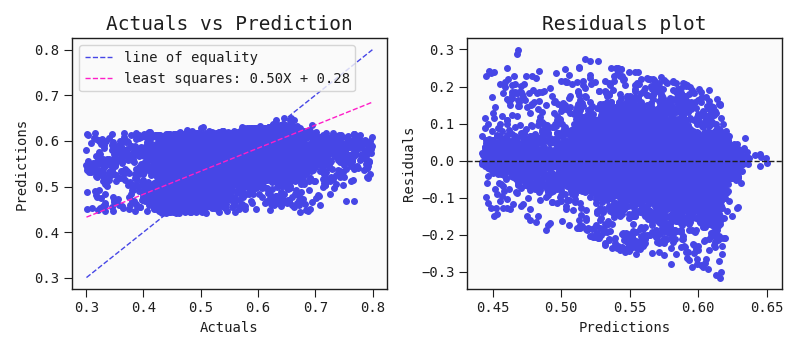
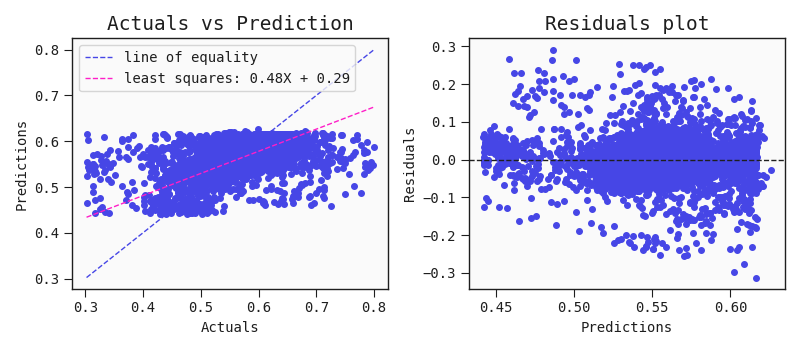

In [ ]:
train, test = split(ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(train.columns, 'ch_sysef', max_complexity=15)

models = feyn.fit_models(models, train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=10
)

best = models[0]
best.plot(
    data=train,
    compare_data=test
)


In [ ]:
root_mean_squared_error(test['ch_sysef'], best.predict(test)) * 100

2.734412142330456

In [ ]:
interactive_activation_flow(best, train)

interactive(children=(FloatSlider(value=316.05403149999995, description='sys_cl', max=599.692322, min=32.41574…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

In [ ]:
len(fil_df)

157776

## Condition for Summer, Rain, Normal Model

RH > 90% AND DB < 26 C as rainy days 
RH < 70% AND DB > 30C as hot days
other conditions as normal days? 

In [27]:
# Summer
summer_fil_df = fil_df[(fil_df['wea_ct_rh']<=70) & (fil_df['wea_ct_db']>=30)]

# Rain
rain_fil_df = fil_df[(fil_df['wea_ct_rh']>=90) & (fil_df['wea_ct_db']<=26)]

# Normal
cond1 = fil_df['timestamp'].isin(summer_fil_df['timestamp'])
cond2 = fil_df['timestamp'].isin(rain_fil_df['timestamp'])
fil_df.drop(fil_df[cond1].index, inplace=True)
fil_df.drop(fil_df[cond2].index, inplace=True)

/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_853/2566096721.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df.drop(fil_df[cond1].index, inplace=True)
/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_853/2566096721.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fil_df.drop(fil_df[cond2].index, inplace=True)
/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_853/2566096721.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df.drop(fil_df[cond2].index, inplace=True)


## Summer model

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="352.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 755 352.0" width="755" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="110.0"><title>ch_sysef
linear:
scale=0.249640
scale offset=0.000000
w=1.411688
bias=2.4713</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">ch_sysef</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="119.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="110.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="131.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="119.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>sys_cl
linear:
scale=0.003526
scale offset=347.782008
w=-1.496401
bias=-0.1096</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>lift
linear:
scale=0.086880
scale offset=23.356465
w=-0.351266
bias=0.6176</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">lift</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="140.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="161.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="149.0">5</text><line stroke="#1E1E1E" x1="91" x2="121" y1="157.5" y2="148.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="217.5" y2="166.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="140.0"><title>lift
linear
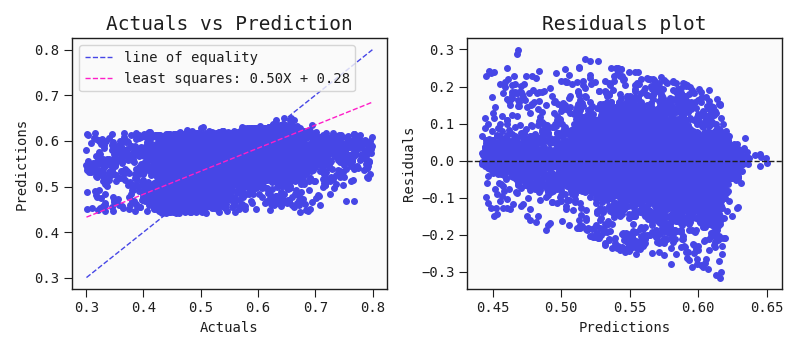
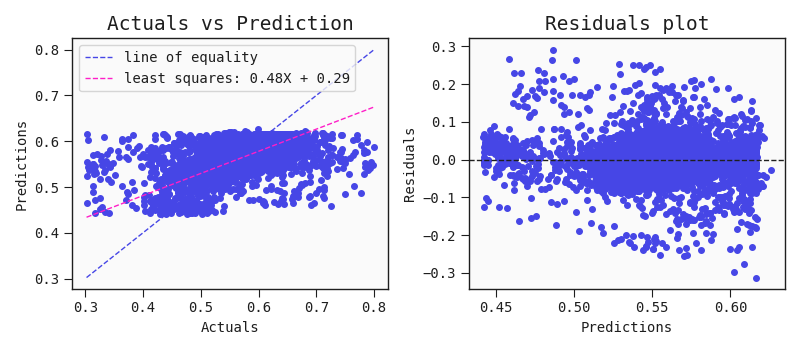

In [31]:
summer_ch_sysef_df = summer_fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

summer_train, summer_test = split(summer_ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(summer_train.columns, 'ch_sysef', max_complexity=15)

models = feyn.fit_models(models, train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=10
)

summer_model = models[0]
summer_model.plot(
    data=train,
    compare_data=test
)

In [32]:
root_mean_squared_error(summer_test['ch_sysef'], summer_model.predict(summer_test)) * 100

1.931208853133484

In [33]:
interactive_activation_flow(summer_model, summer_train)

interactive(children=(FloatSlider(value=287.2637175, description='sys_cl', max=542.111694, min=32.415741), Flo…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

## Rain model

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="352.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 755 352.0" width="755" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="110.0"><title>ch_sysef
linear:
scale=0.249640
scale offset=0.000000
w=1.411688
bias=2.4713</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">ch_sysef</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="119.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="110.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="131.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="119.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>sys_cl
linear:
scale=0.003526
scale offset=347.782008
w=-1.496401
bias=-0.1096</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>lift
linear:
scale=0.086880
scale offset=23.356465
w=-0.351266
bias=0.6176</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">lift</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="140.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="161.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="149.0">5</text><line stroke="#1E1E1E" x1="91" x2="121" y1="157.5" y2="148.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="217.5" y2="166.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="140.0"><title>lift
linear
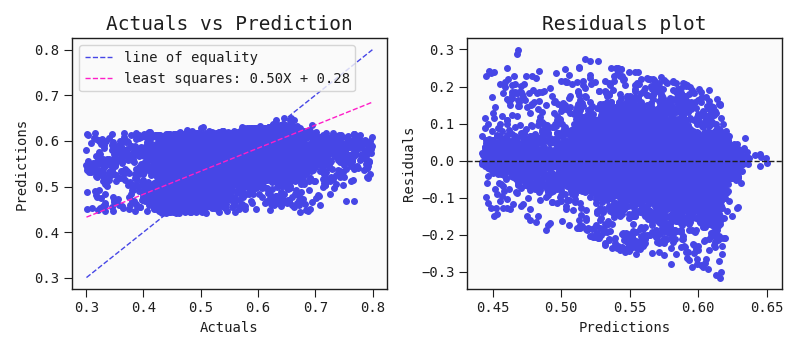
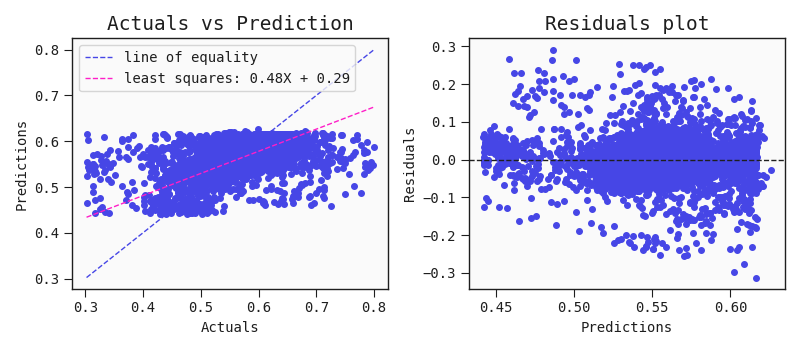

In [34]:
rain_ch_sysef_df = rain_fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

rain_train, rain_test = split(rain_ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(rain_train.columns, 'ch_sysef', max_complexity=15)

models = feyn.fit_models(models, train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=10
)

rain_model = models[0]
rain_model.plot(
    data=train,
    compare_data=test
)

In [35]:
root_mean_squared_error(rain_test['ch_sysef'], rain_model.predict(rain_test)) * 100

2.8942712614110087

In [36]:
interactive_activation_flow(rain_model, rain_train)

interactive(children=(FloatSlider(value=328.46424849999994, description='sys_cl', max=585.906982, min=71.02151…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

## Normal model

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="352.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 755 352.0" width="755" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="110.0"><title>ch_sysef
linear:
scale=0.249640
scale offset=0.000000
w=1.411688
bias=2.4713</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">ch_sysef</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="119.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="110.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="131.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="119.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>sys_cl
linear:
scale=0.003526
scale offset=347.782008
w=-1.496401
bias=-0.1096</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>lift
linear:
scale=0.086880
scale offset=23.356465
w=-0.351266
bias=0.6176</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">lift</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="140.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="161.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="149.0">5</text><line stroke="#1E1E1E" x1="91" x2="121" y1="157.5" y2="148.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="217.5" y2="166.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="140.0"><title>lift
linear
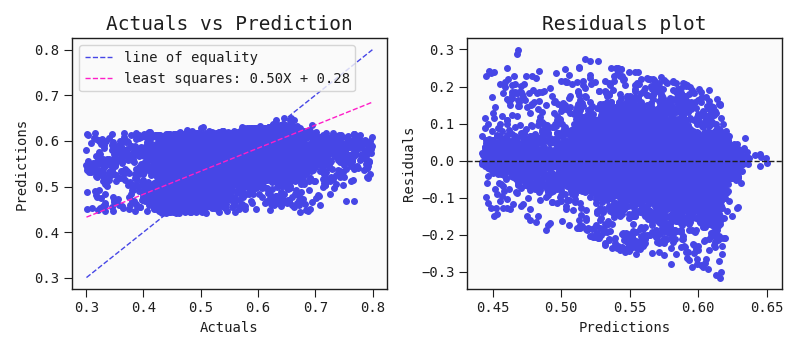
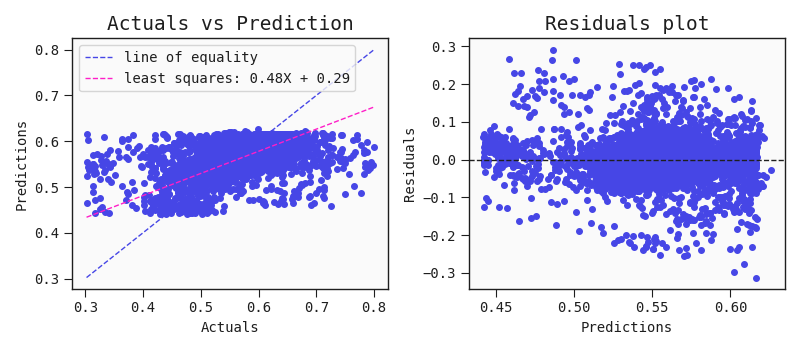

In [37]:
normal_ch_sysef_df = rain_fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

normal_train, normal_test = split(normal_ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(normal_train.columns, 'ch_sysef', max_complexity=15)

models = feyn.fit_models(models, train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=10
)

normal_model = models[0]
normal_model.plot(
    data=train,
    compare_data=test
)

In [38]:
root_mean_squared_error(normal_test['ch_sysef'], normal_model.predict(rain_test)) * 100

4.10901671450554

In [39]:
interactive_activation_flow(normal_model, normal_train)

interactive(children=(FloatSlider(value=328.46424849999994, description='sys_cl', max=585.906982, min=71.02151…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

In [42]:
print(len(rain_ch_sysef_df), len(summer_ch_sysef_df), len(fil_df))

5889 28640 123247
